In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
df = pd.read_excel("C:/Users/auuser/Desktop/csc 680/final project/Telco_customer_churn.xlsx") 

print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum()) 

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

In [5]:
print(df.shape)

(7043, 33)


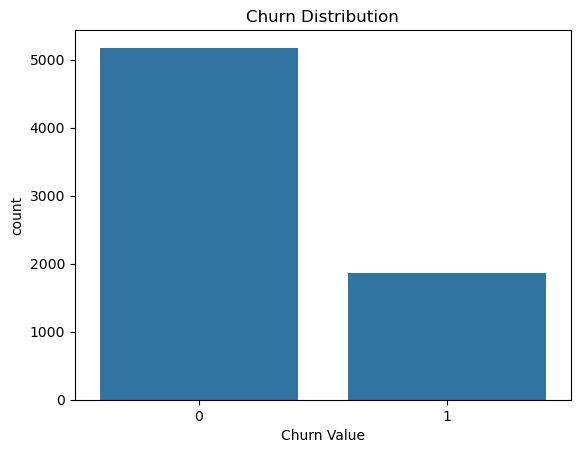

In [7]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# impute missing values
df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].median())

# Encode categorical features
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Churn Value':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# EDA plot: Churn Distribution
sns.countplot(x='Churn Value', data=df)
plt.title('Churn Distribution')
plt.show()

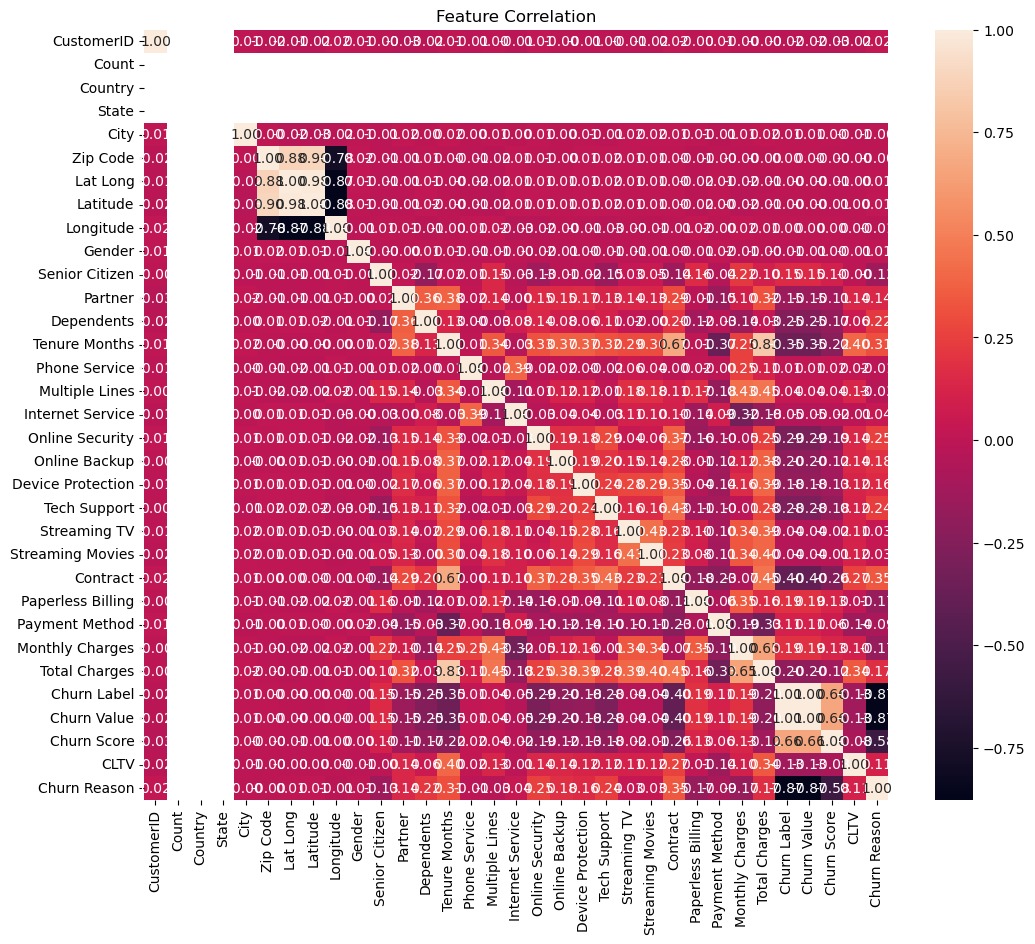

In [9]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title('Feature Correlation')
plt.show()

            Feature  Importance
27      Churn Score    0.451619
22         Contract    0.098889
12    Tenure Months    0.054230
11       Dependents    0.039229
16  Online Security    0.037177
19     Tech Support    0.034444
25  Monthly Charges    0.029592
26    Total Charges    0.026250
24   Payment Method    0.025408
28             CLTV    0.021921


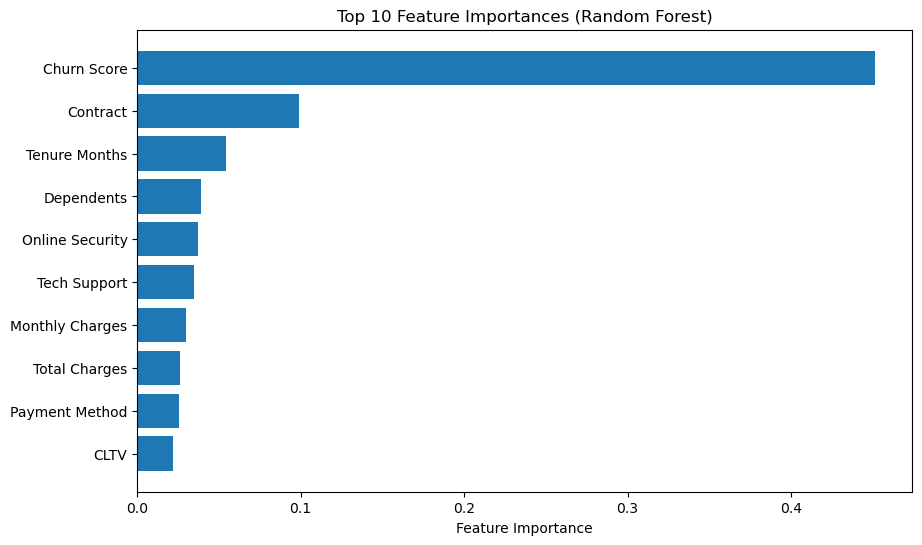

In [37]:
# Random Forest Feature Importance
importances = rf.feature_importances_
feature_names = X.columns

# 📝 Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df.head(10))

plt.figure(figsize=(10,6))
plt.barh(feature_importances_df['Feature'][:10], feature_importances_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

In [13]:
#  Without SMOTE
df_model = df.drop(['CustomerID', 'Churn Label', 'Churn Reason', 'City', 'Zip Code'], axis=1)

X = df_model.drop('Churn Value', axis=1)  # All columns except the target
y = df_model['Churn Value']  # Target column

# Train-test split (80% train, 20% test) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# shape of X_train and y_train
print(f"Original train set shape: {X_train.shape}, {y_train.shape}")

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Original train set shape: (5634, 29), (5634,)


In [15]:
#  Logistic Regression without smote
print("Logistic Regression without smote:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

Logistic Regression:
[[974  61]
 [ 56 318]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1035
           1       0.84      0.85      0.84       374

    accuracy                           0.92      1409
   macro avg       0.89      0.90      0.89      1409
weighted avg       0.92      0.92      0.92      1409

ROC AUC: 0.9741894649823039


In [17]:
#  Random Forest without smote
print("\nRandom Forest without smote:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


Random Forest:
[[989  46]
 [ 45 329]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1035
           1       0.88      0.88      0.88       374

    accuracy                           0.94      1409
   macro avg       0.92      0.92      0.92      1409
weighted avg       0.94      0.94      0.94      1409

ROC AUC: 0.9786496680358573


In [19]:
#  With SMOTE
X = df_model.drop('Churn Value', axis=1)  # All columns except the target
y = df_model['Churn Value']  # Target column

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

#Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# shape of X_train_res and y_train_res
print(f"Original train set shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled train set shape: {X_train_res.shape}, {y_train_res.shape}")

# Modeling: Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)

# Modeling: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

Original train set shape: (5634, 29), (5634,)
Resampled train set shape: (8278, 29), (8278,)


In [21]:
#  Logistic Regression
print("Logistic Regression:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

Logistic Regression:
[[948  87]
 [ 31 343]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1035
           1       0.80      0.92      0.85       374

    accuracy                           0.92      1409
   macro avg       0.88      0.92      0.90      1409
weighted avg       0.92      0.92      0.92      1409

ROC AUC: 0.97335503371309


In [23]:
#  Random Forest
print("\nRandom Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


Random Forest:
[[964  71]
 [ 38 336]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1035
           1       0.83      0.90      0.86       374

    accuracy                           0.92      1409
   macro avg       0.89      0.91      0.90      1409
weighted avg       0.93      0.92      0.92      1409

ROC AUC: 0.9778010281846599


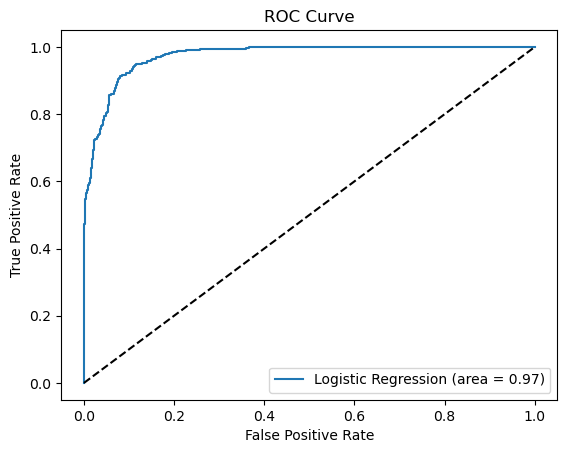

In [25]:
# ROC Curve (Logistic Regression)
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show() 

In [27]:
from sklearn.neural_network import MLPClassifier
# MLP 
mlp = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

In [28]:
# MLP
print("\n MLP Classifier Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))
roc_auc_mlp = roc_auc_score(y_test, y_pred_mlp)
print(f"ROC AUC: {roc_auc_mlp:.4f}")


📊 MLP Classifier Metrics:
Accuracy: 0.8977998580553584
Confusion Matrix:
 [[957  78]
 [ 66 308]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1035
           1       0.80      0.82      0.81       374

    accuracy                           0.90      1409
   macro avg       0.87      0.87      0.87      1409
weighted avg       0.90      0.90      0.90      1409

ROC AUC: 0.8741


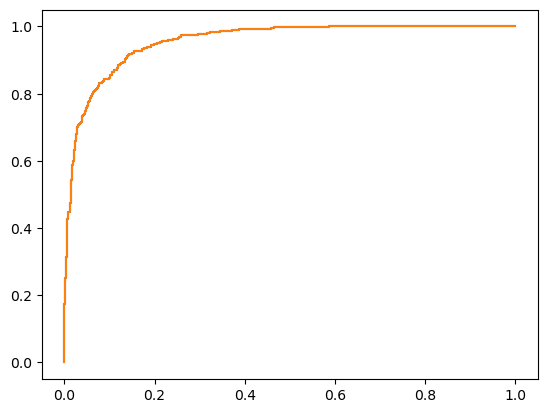

In [33]:
# ROC Curve for MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP Classifier (AUC = {roc_auc_mlp:.4f})')
plt.show()